In [1]:
import sys
sys.path.append('C:\\Users\\DavidB\\PycharmProjects\\My_Football_Analytics\\Basics')
sys.path.append('C://Users//DavidB//PycharmProjects//My_Football_Analytics//Position_data')

import pandas as pd
import numpy as np
import torch
from torch.nn.functional import softplus
import Data.Metrica_IO as mio
from Tracking_Data import tracking_data
import pitch_control
import matplotlib.pyplot as plt

away_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv', skiprows=2)
home_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv', skiprows=2)

# positions of players and ball as numpy.ndarray
locs_home = np.array([np.asarray(home_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(14)]) * np.array([120,80])
locs_away = np.array([np.asarray(away_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(14)]) * np.array([120,80])
locs_ball = np.asarray(home_data.iloc[:,range(31,33)]) * np.array([120,80])

# time colum as pandas.core.series.Series
tt = home_data['Time [s]']

# event data dataframe
event_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawEventsData.csv')


In [2]:
# supposed to be based on td_object --> first create one
# everywhere we call the object now will later be self

data_dir = 'sample-data-master/data/'
game_id = 1
away = mio.tracking_data(DATADIR=data_dir, game_id=game_id, teamname='Away')
home = mio.tracking_data(DATADIR=data_dir, game_id=game_id, teamname='Home')
td = mio.merge_tracking_data(home, away)
td_object = tracking_data(td, data_source='metrica', scale_to_pitch='mplsoccer')
td_object.get_velocities()

td_object

Reading team: away
Reading team: home


In [86]:
jitter = 1e-12 # to avoid division by zero when players are standing still

# convert to tensor (n_players, n_frames, 2)
# GPU versions of data if available via cuda function
xy_home = torch.Tensor(locs_home)
xy_away = torch.Tensor(locs_away)
xy_ball = torch.Tensor(locs_ball)
ttt = torch.Tensor(tt)

# x & y velocity components
# removes first frame for some reason
dt = ttt[1:] - ttt[:-1]
sxy_home = (xy_home[:,1:,:] - xy_home[:,:-1,:])/dt[:,None] + jitter
sxy_away = (xy_away[:,1:,:] - xy_away[:,:-1,:])/dt[:,None] + jitter

# speed via pythagoras for each x-y-combination (=dimension 2)
s_home = torch.sqrt(torch.sum(sxy_home**2,2))
s_away = torch.sqrt(torch.sum(sxy_away**2,2))

# angles of travel
theta_home = torch.acos(sxy_home[:,:,0] / s_home)
theta_away = torch.acos(sxy_away[:,:,0] / s_away)

# means for player influence functions (mu)
# gamma = 0.5
mu_home = xy_home[:,:-1,:] + 0.5*sxy_home
mu_away = xy_away[:,:-1,:] + 0.5*sxy_away

# proportion of max. speed
# max speed = 13m/s
# maximal rate of 1 (i.e. excluding faster than assumed max speed
# according to Fernandez (2018) eq. (18) this is not correct
Srat_home = torch.min((s_home / 13.0)**2,torch.Tensor([1]))
Srat_away = torch.min((s_away / 13.0)**2,torch.Tensor([1]))

# influence radius
Ri_home = torch.min(4 + torch.sqrt(torch.sum((xy_ball - xy_home)**2,2))**3 / 972,torch.Tensor([10]))
Ri_away = torch.min(4 + torch.sqrt(torch.sum((xy_ball - xy_away)**2,2))**3 / 972,torch.Tensor([10]))

# inverses of covariance matrices -- Sigma^{-1} = RS^{-1}S^{-1}R^T. only need RS^{-1} to evaluate gaussian.

# create tensor with zeros to be filled
RSinv_home = torch.Tensor(s_home.shape[0],s_home.shape[1],2,2)
RSinv_away = torch.Tensor(s_home.shape[0],s_home.shape[1],2,2)

# s for S matrix
S1_home = 2 / ((1+Srat_home) * Ri_home[:,:-1])
S2_home = 2 / ((1-Srat_home) * Ri_home[:,:-1])
S1_away = 2 / ((1+Srat_away) * Ri_away[:,:-1])
S2_away = 2 / ((1-Srat_away) * Ri_away[:,:-1])

# RS^-1 as the sum of S and the angle from R (A) 
RSinv_home[:,:,0,0] = S1_home * torch.cos(theta_home)
RSinv_home[:,:,1,0] = S1_home * torch.sin(theta_home)
RSinv_home[:,:,0,1] = - S2_home * torch.sin(theta_home)
RSinv_home[:,:,1,1] = S2_home * torch.cos(theta_home)

RSinv_away[:,:,0,0] = S1_away * torch.cos(theta_away)
RSinv_away[:,:,1,0] = S1_away * torch.sin(theta_away)
RSinv_away[:,:,0,1] = - S2_away * torch.sin(theta_away)
RSinv_away[:,:,1,1] = S2_away * torch.cos(theta_away)
# denominators for individual player influence functions (see eq 1 in paper). Note the normalising factors 
# for the multivariate normal distns (eq 12) 
#cancel, so don't need to bother computing them.
denominators_h = torch.exp(-0.5 * torch.sum(((xy_home[:,:-1,None,:] - mu_home[:,:,None,:]).matmul(RSinv_home))**2,-1))
denominators_a = torch.exp(-0.5 * torch.sum(((xy_away[:,:-1,None,:] - mu_away[:,:,None,:]).matmul(RSinv_away))**2,-1))


# set up query points for evaluating pitch control
n_grid_points_x = 50
n_grid_points_y = 30
xy_query = torch.stack([torch.linspace(0,120,n_grid_points_x).repeat(n_grid_points_y),torch.repeat_interleave(torch.linspace(0, 80,n_grid_points_y),n_grid_points_x)],1)
     

In [87]:
# specify frames of interest
first_frame = 0
#n_frames = sxy_home.shape[1]
n_frames = 250

# add some dimensions to query array for broadcasting purposes
xyq = xy_query[None,None,:,:]
# all target locations for all frames
pitch_control = torch.Tensor(n_frames,xy_query.shape[0])

#batch_size sets number of frames to be processed at once. decrease if there's a cuda memory error.
batch_size = 250

for f in range(int(n_frames/batch_size)):
    print(f)
    # substract means from query points = p-mu
    # but this is mu - p
    xminmu_h = mu_home[:,(first_frame + f*batch_size):
                       (np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),None,:] - xyq
    # multiply (mu - x) obtained above by RS^{-1}
    mm_h = xminmu_h.matmul(RSinv_home[:,(first_frame + f*batch_size):
                                      (np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:,:])
    # mm_h = (p-mu) * RS^-1
    # infl_h = mm_h^2 = ((p-mu) * RS^-1)^2 = (p-mu) * RS^-1 * (p-mu) * RS^-1) = (p-mu) * SIGMA * (p-mu)
    infl_h = torch.exp(-0.5 * torch.sum(mm_h**2,-1))
    # infl_h = exponent of f
    infl_h = infl_h / denominators_h[:,(first_frame + f*batch_size):
                                     (np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:]
    
    xminmu_a = mu_away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),None,:] - xyq
    mm_a = xminmu_a.matmul(RSinv_away[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:,:])
    infl_a = torch.exp(-0.5 * torch.sum(mm_a**2,-1))
    infl_a = infl_a / denominators_a[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames))),:]
    
    # missing values --> 0
    isnan_h = torch.isnan(infl_h)
    isnan_a = torch.isnan(infl_a)
    infl_h[isnan_h] = 0
    infl_a[isnan_a] = 0
    
    
    # based on both teams influence areas we calculate the pitch control by transforming the delta into
    # a probability via the sigmoid function
    pitch_control[(f*batch_size):
                  (np.minimum((f+1)*batch_size,int(n_frames))),:] = torch.sigmoid(torch.sum(infl_h,0) - torch.sum(infl_a,0))




0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


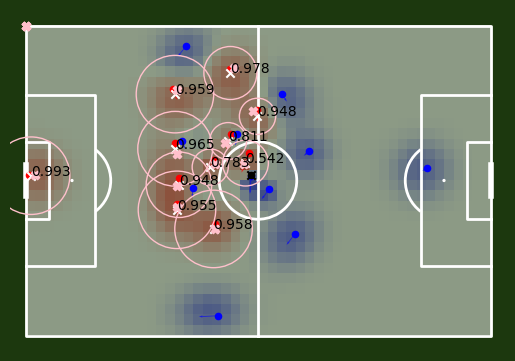

In [88]:
import matplotlib.pyplot as plt
f = 100
fig, ax = td_object.plot_players(frame=f, velocities=True)


ax.imshow(pitch_control[f].reshape(n_grid_points_y,n_grid_points_x),extent = (0,120, 80, 0), 
          cmap='bwr', alpha=0.5, vmin=0.0, vmax=1.0)
ax.scatter(mu_home[:, f, 0], mu_home[:, f, 1], marker='x', color = 'white')
ax.scatter(xy_ball[f, 0], xy_ball[f,1], color='black', marker='x')
for p in range(len(Ri_home)):
    cir = plt.Circle((mu_home[p, f, 0], mu_home[p, f, 1]), fill=False, radius = Ri_home[p, 0], color='pink')
    ax.add_patch(cir)
    ax.text(mu_home[p, f, 0], mu_home[p, f, 1], s=str(round(denominators_h[p,f].item(), 3)))
    i = infl_h[p, f, :].argmax()
    ax.scatter(xyq[:, :, i][0][0][0], xyq[:, :, i][0][0][1], color='pink', marker='X')

In [89]:
for p in range(len(Ri_home)):
    print(p)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [30]:
sxy_away[:, 0]

tensor([[-4.5013e-01,  1.0000e-12],
        [ 1.0000e-12,  1.0000e-12],
        [ 1.0000e-12,  1.0000e-12],
        [ 1.0000e-12,  1.0000e-12],
        [ 1.0000e-12,  1.0000e-12],
        [ 1.0000e-12,  1.0000e-12],
        [ 1.0000e-12,  1.0000e-12],
        [ 1.0000e-12,  1.0000e-12],
        [ 1.0000e-12,  1.0000e-12],
        [ 1.0000e-12,  1.0000e-12],
        [ 1.0000e-12,  1.0000e-12],
        [        nan,         nan],
        [        nan,         nan],
        [        nan,         nan]])

In [82]:
infl_h[0, 1, :]

tensor([1.0457e-13, 9.8615e-14, 7.7445e-14,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00])

In [29]:
pitch_control[1]

tensor([0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000])

In [ ]:
xy_away

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def RI(distance_to_ball, exp=3, div=972):
    ri = np.min([4 + distance_to_ball**exp /div, 10])
    return ri

dtb = np.arange(0, 30, 0.01)
ris = [RI(x) for x in dtb]
plt.plot(dtb, ris)

In [ ]:
np.random.logistic()

In [ ]:
np.exp(2)/np.exp(3)

In [ ]:
2/3

In [ ]:
td_object.dimensions

In [40]:
xy_query[750]

tensor([ 0.0000, 35.1724])

In [52]:
infl_h[0, 0, :].argmax()

tensor(807)

In [61]:
infl_h[0, 0, 807]

tensor(0.9949)

In [62]:
infl_h.shape

torch.Size([14, 250, 1500])

In [56]:
807/50, 807%50

(16.14, 7)

In [85]:
xyq

tensor([[[[  0.0000,   0.0000],
          [  2.1429,   0.0000],
          [  4.2857,   0.0000],
          ...,
          [100.7143,  68.0000],
          [102.8571,  68.0000],
          [105.0000,  68.0000]]]])